In [ ]:
# MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# 1_Exercise_multi-class classification on Stack Overflow questions

This tutorial showed how to train a binary classifier from scratch on the IMDB dataset. As an exercise, you can modify this notebook to train a multi-class classifier to predict the tag of a programming question on Stack Overflow.

A dataset has been prepared for you to use containing the body of several thousand programming questions (for example, "How can I sort a dictionary by value in Python?") posted to Stack Overflow. Each of these is labeled with exactly one tag (either Python, CSharp, JavaScript, or Java). Your task is to take a question as input, and predict the appropriate tag, in this case, Python.

The dataset you will work with contains several thousand questions extracted from the much larger public Stack Overflow dataset on BigQuery, which contains more than 17 million posts.

After downloading the dataset, you will find it has a similar directory structure to the IMDB dataset you worked with previously:

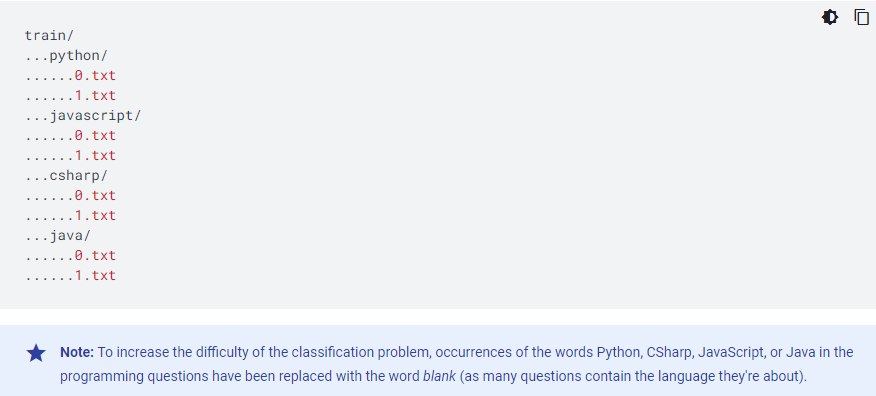

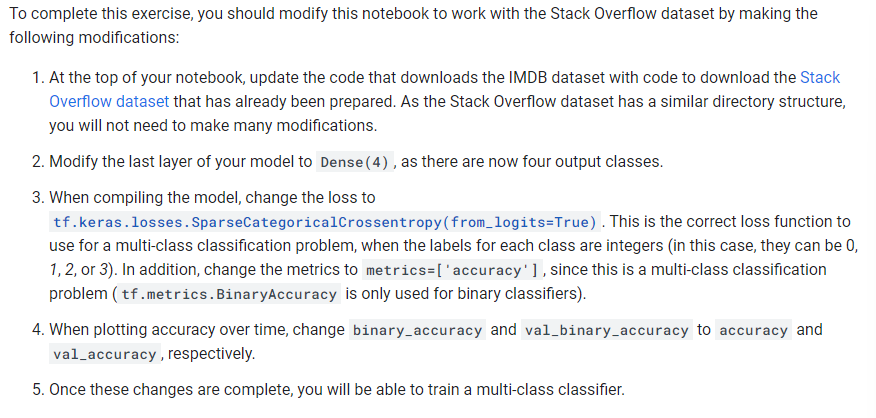

#### Import Libraries

In [6]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import numpy as np

from tensorflow.keras import layers
from tensorflow.keras import losses

#### Download Dataset

In [19]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

dataset = tf.keras.utils.get_file("stack_overflow_16k", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='stack_overflow')

dataset_dir = os.path.join(os.path.dirname(dataset))

In [20]:
os.listdir(dataset_dir)

['README.md', 'stack_overflow_16k.tar.gz', 'test', 'train']

In [21]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['csharp', 'java', 'javascript', 'python']

#### Create Training, Test, and Validation Sets

In [22]:
batch_size = 32
seed = 42

#Training set
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'stack_overflow/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [23]:
#Validation set
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'stack_overflow/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [24]:
#Test set - already exist under test folder
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'stack_overflow/test',
    batch_size=batch_size)

Found 8000 files belonging to 4 classes.


In [25]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(4):
    print(f"Review: {text_batch.numpy()[i]}")
    print(f"Label: {label_batch.numpy()[i]}")
    print("-----------")

Review: b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default constr

In [27]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])
print("Label 2 corresponds to", raw_train_ds.class_names[2])
print("Label 3 corresponds to", raw_train_ds.class_names[3])

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


In [28]:
#Constants
max_features = 10000
sequence_length = 250

In [29]:
vectorize_layer = layers.TextVectorization(
    standardize=None, #we keep the punctuations and text cases as it may be important in codes
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [30]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x) #lambda - takes two inputs x and y, and only returns x
vectorize_layer.adapt(train_text)

In [31]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [32]:
#Vectorize all our datasets
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [33]:
#Configure dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Create model

In [34]:
embedding_dim = 16

In [38]:
model = tf.keras.Sequential([
  layers.Embedding(max_features, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(4)
  ])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [39]:
#Compile model
model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

In [40]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2990 - loss: 1.3764 - val_accuracy: 0.4638 - val_loss: 1.3443
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4268 - loss: 1.3319 - val_accuracy: 0.5419 - val_loss: 1.2841
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4889 - loss: 1.2644 - val_accuracy: 0.6075 - val_loss: 1.2040
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5571 - loss: 1.1824 - val_accuracy: 0.6513 - val_loss: 1.1195
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6125 - loss: 1.0963 - val_accuracy: 0.6862 - val_loss: 1.0412
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6476 - loss: 1.0194 - val_accuracy: 0.7000 - val_loss: 0.9698
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6836 - loss: 0.9532 - val_accuracy: 0.7256 - val_loss: 0.9107
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7006 - loss: 0.8914 - val_accuracy: 0.

In [41]:
#Evaluate model
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7263 - loss: 0.8112
Loss:  0.8143133521080017
Accuracy:  0.7239999771118164


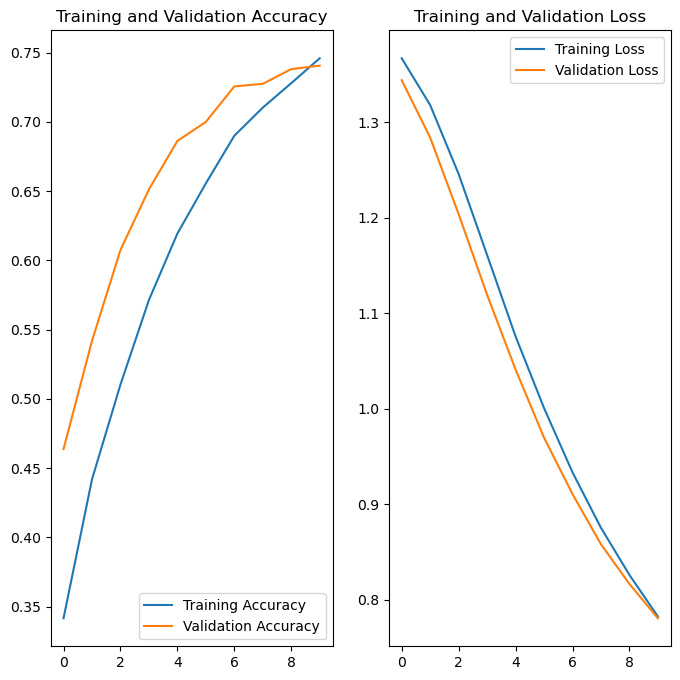

In [42]:
#Accuracy and loss over epochs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Export Model

In [61]:
export_model = tf.keras.Sequential([
  vectorize_layer, #add vectorize layer
  model
])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.7256 - loss: 0.8121
0.7239999771118164


#### Prediction on old data

In [82]:
examples = tf.constant([
  text_batch.numpy()[0],
  text_batch.numpy()[1]
])

predictions = export_model.predict(examples)

for i in range(len(examples)):
    predicted_class = np.argmax(predictions[i])
    print(raw_train_ds.class_names[predicted_class])
    print(raw_train_ds.class_names[label_batch.numpy()[i]])
    print('-----')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
java
java
-----
python
python
-----


#### Inference on new data

In [85]:
examples = tf.constant([
  '''
You're tasked with developing a Java application to manage a bank account system. The system should handle the following functionalities:

Create a BankAccount class with attributes like account number (String), balance (double), and account holder name (String).
Implement methods for depositing and withdrawing money (deposit(double amount) and withdraw(double amount)).
Enforce a minimum balance requirement (e.g., $50). Withdrawals that would cause the balance to fall below the minimum should throw a MinimumBalanceException (a custom exception class you create).
Include a toString method to provide a string representation of the account information (account number, balance, and name).
Question:

Complete the Java code for the BankAccount class, including the constructor, deposit, withdraw, toString, and the MinimumBalanceException class.
Bonus:

Modify the BankAccount class to include an interest rate attribute (double) and a method calculateInterest() that calculates the interest earned based on the current balance and the interest rate.
''',
'''
Here's a random Python code question that tests your skills in recursion and data structures:

Scenario:

You're working on a file system explorer program. You need to write a Python function that takes a directory path as input and returns a list containing the absolute paths of all files (excluding directories) within that directory and its subdirectories recursively.

Question:

Write a Python function named get_all_files(directory_path) that achieves the following:

The function takes a string representing the directory path as input.
It uses recursion to traverse through all subdirectories within the provided directory.
During the traversal, it identifies all files (not directories) and adds their absolute paths to a list.
The function returns the final list containing the absolute paths of all files found recursively.
Bonus:

Modify the function to accept an optional argument extensions (a list of strings) that specifies file extensions to filter by. The function should only return files with extensions present in the extensions list.
'''
])

predictions = export_model.predict(examples)

for i in range(len(examples)):
    predicted_class = np.argmax(predictions[i])
    print(raw_train_ds.class_names[predicted_class])
    print('-----')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
java
-----
python
-----
